# Sentiment Analysis for It EndsWith Us Trailer 

## Data from youtube

The code used for data extraction was found from a Medium atricle and adapted using ChatGPT

In [49]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from time import sleep

In [50]:
driver = webdriver.Chrome()
driver.set_page_load_timeout(100)
driver.get('https://www.youtube.com/')
driver.maximize_window()
sleep(20)

In [51]:
search = driver.find_element(By.NAME, "search_query")
search.clear()
search.send_keys("IT ENDS WITH US - Official Trailer (HD)")
search.send_keys(Keys.ENTER)
sleep(60)
link = driver.find_element(By.XPATH, """//*[@id="video-title"]/yt-formatted-string""")
link.click()
sleep(20)

In [52]:
for i in range(500):  
    driver.execute_script("window.scrollBy(0, 800)", "") 
    sleep(1)  


In [53]:
list = []

comment = driver.find_elements(By.XPATH, """//*[@id="content-text"]/span""")
for i in comment:
    list.append(i.text)
    
print(list)
print(len(list))


['The best words of this book is when Atlas says- "In the future... if by some miracle you ever find yourself in the position of fall in love again, fall in love with me. You\'re still my favourite person Lily".  Best words ever', '"Fifteen seconds. That’s all it takes to completely change everything about a person. Fifteen seconds that we’ll never get back." This line always hits hard', "this looks way better than I was expecting. the flower shop is exactly what I envisioned. still not sold on the guy playing Atlas, but that's okay!", 'PSA: if he hits you once, it’ll happen again. Leave. Don’t look back. You can find someone better, someone who actually loves you and treats you with respect.', 'all the feels from reading the book came back especially that last part of “if one day you had a daughter, what would you say to her?” ima cry in the theater!', '15 seconds that all it takes, still remembering reading this n it just blew my brains off i cried like a baby.', "This is the exact r

In [54]:
import pandas as pd
df = pd.DataFrame({"comment": list})
df.to_csv("trailer_comments.csv", index=False)

In [55]:
assert "No results found." not in driver.page_source
driver.close()

## Importing Libraries

In [117]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import emoji
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils import resample
from lightgbm import LGBMClassifier
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import inflect

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Import Data 

In [118]:
df=pd.read_csv('trailer_comments.csv')
df

,comment
0,The best words of this book is when Atlas says...
1,"""Fifteen seconds. That’s all it takes to compl..."
2,this looks way better than I was expecting. th...
3,"PSA: if he hits you once, it’ll happen again. ..."
4,all the feels from reading the book came back ...
...,...
1103,Hollywood just can't make anything interesting...
1104,עם התחלה חזקה במוסיקה ואימא שלו שופכת עליו דבש...
1105,Blake always trying hard to be Kate Hudson but...
1106,Interracial movie no thanks.


The comments have been sucessfully loaded into the dataframe, ready for preprocessing and modelling 

## Data Preprocessing

In [119]:
p = inflect.engine()

In [120]:
def preprocess_text(text):
    if isinstance(text, str): 
        text = emoji.demojize(text)  
        text = re.sub(r"http\S+", "", text) 
        text = re.sub(r'[^A-Za-z0-9\s]', '', text) 
        text = ' '.join([p.number_to_words(word) if word.isdigit() else word for word in text.split()])  # Convert numbers to words
        text = text.lower()
        text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
        return text
    else:
        return ""  

The function converts emojis to text, removes URLs and punctuation, converts numbers to words, transforms the text to lowercase, and removes stopwords.

In [121]:
df['cleaned_comment'] = df['comment'].apply(preprocess_text)
df

,comment,cleaned_comment
0,The best words of this book is when Atlas says...,best words book atlas says future miracle ever...
1,"""Fifteen seconds. That’s all it takes to compl...",fifteen seconds thats takes completely change ...
2,this looks way better than I was expecting. th...,looks way better expecting flower shop exactly...
3,"PSA: if he hits you once, it’ll happen again. ...",psa hits itll happen leave dont look back find...
4,all the feels from reading the book came back ...,feels reading book came back especially last p...
...,...,...
1103,Hollywood just can't make anything interesting...,hollywood cant make anything interesting anymo...
1104,עם התחלה חזקה במוסיקה ואימא שלו שופכת עליו דבש...,ten
1105,Blake always trying hard to be Kate Hudson but...,blake always trying hard kate hudson never tin...
1106,Interracial movie no thanks.,interracial movie thanks


In [122]:
sentiments=SentimentIntensityAnalyzer()

In [123]:
df['Positive']=df['cleaned_comment'].apply(lambda x:sentiments.polarity_scores(x)['pos'])
df['Negative'] = df['cleaned_comment'].apply(lambda x: sentiments.polarity_scores(x)['neg'])
df['Neutral']=df['cleaned_comment'].apply(lambda x: sentiments.polarity_scores(x)['neu'])
df['Compound']=df['cleaned_comment'].apply(lambda x: sentiments.polarity_scores(x)['compound'])

In [124]:
def classify_sentiment(compound):
    if compound >= 0.05:
        return 'Positive'
    elif compound <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

SentimentIntensityAnalyzer was used to analyze the sentiment of text in the cleaned_comment column.
It calculates individual scores for positive, negative, neutral, and compound sentiments.
The classify_sentiment function uses the compound score to label each comment's sentiment as Positive, Negative, or Neutral

In [125]:
df['sentiment']=df['Compound'].apply(classify_sentiment)
y=df['sentiment']
df

,comment,cleaned_comment,Positive,Negative,Neutral,Compound,sentiment
0,The best words of this book is when Atlas says...,best words book atlas says future miracle ever...,0.548,0.000,0.452,0.9705,Positive
1,"""Fifteen seconds. That’s all it takes to compl...",fifteen seconds thats takes completely change ...,0.108,0.072,0.821,0.1779,Positive
2,this looks way better than I was expecting. th...,looks way better expecting flower shop exactly...,0.355,0.000,0.645,0.6808,Positive
3,"PSA: if he hits you once, it’ll happen again. ...",psa hits itll happen leave dont look back find...,0.424,0.052,0.524,0.8591,Positive
4,all the feels from reading the book came back ...,feels reading book came back especially last p...,0.000,0.171,0.829,-0.4767,Negative
...,...,...,...,...,...,...,...
1103,Hollywood just can't make anything interesting...,hollywood cant make anything interesting anymo...,0.206,0.176,0.618,0.1882,Positive
1104,עם התחלה חזקה במוסיקה ואימא שלו שופכת עליו דבש...,ten,0.000,0.000,1.000,0.0000,Neutral
1105,Blake always trying hard to be Kate Hudson but...,blake always trying hard kate hudson never tin...,0.000,0.097,0.903,-0.1027,Negative
1106,Interracial movie no thanks.,interracial movie thanks,0.592,0.000,0.408,0.4404,Positive


In [126]:
df_cleaned=df.drop(['Positive','Negative','Neutral','Compound','comment'],axis=1)
df_cleaned.head()

,cleaned_comment,sentiment
0,best words book atlas says future miracle ever...,Positive
1,fifteen seconds thats takes completely change ...,Positive
2,looks way better expecting flower shop exactly...,Positive
3,psa hits itll happen leave dont look back find...,Positive
4,feels reading book came back especially last p...,Negative


In [127]:
le = LabelEncoder()
df['sentiment'] = le.fit_transform(df['sentiment'])

A numerical value is assigned to each sentiment 
0 -negative
1-neutral
2-positive

It is done because
It simplifies the representation of the sentiment data, making it easier to store and work with.
Most algorithms require numeric input, and by assigning numerical values to each sentiment, the model can process and learn from this data.

In [129]:
df['sentiment'].value_counts()

sentiment
2    477
1    316
0    315
Name: count, dtype: int64

Because there is not an equal number of positive,negative and neutral we can upsample the minorities

In [131]:
df_neutral = df[(df['sentiment']==1)] 
df_negative = df[(df['sentiment']==0)]
df_positive = df[(df['sentiment']==2)]


# upsample minority classes
df_negative_upsampled = resample(df_negative,
                                 replace=True,    
                                 n_samples= 477, 
                                 random_state=42)  

df_neutral_upsampled = resample(df_neutral, 
                                 replace=True,    
                                 n_samples= 477, 
                                 random_state=42)  


final_data = pd.concat([df_negative_upsampled,df_neutral_upsampled,df_positive])

In [133]:
final_data

,comment,cleaned_comment,Positive,Negative,Neutral,Compound,sentiment
324,cried a lot watching this movie,cried lot watching movie,0.000,0.464,0.536,-0.3818,0
983,All the feminist propaganda is tiring. Cant Ho...,feminist propaganda tiring cant hollywood make...,0.000,0.386,0.614,-0.5277,0
340,I didn’t picture anyone to look like this bro....,didnt picture anyone look like bro atlas head ...,0.108,0.199,0.693,-0.4767,0
237,So I just heard that there's some controversy ...,heard theres controversy people realizing ther...,0.125,0.223,0.652,-0.4215,0
694,I will never watch a movie the book i have rea...,never watch movie book read completely destroy...,0.000,0.333,0.667,-0.5413,0
...,...,...,...,...,...,...,...
1083,The problem in this movie is obviously this co...,problem movie obviously confused woman biggest...,0.262,0.260,0.478,0.0516,2
1090,"So cheesy, but it's what the women like",cheesy women like,0.556,0.000,0.444,0.3612,2
1095,lol this movie looks like shit,lol movie looks like shit,0.486,0.330,0.183,0.1779,2
1103,Hollywood just can't make anything interesting...,hollywood cant make anything interesting anymo...,0.206,0.176,0.618,0.1882,2


In [134]:
comms = final_data['cleaned_comment'].tolist()
cv = CountVectorizer(max_features=1500)
X = cv.fit_transform(comms).toarray()
y = final_data['sentiment'].values


## Modelling

In [136]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.4,random_state=42)

## Naive Bayes Model

In [142]:
classifier=GaussianNB()

In [148]:
classifier.fit(X_train,y_train)

GaussianNB()

In [149]:
y_pred = classifier.predict(X_test)

## Random Forest

In [146]:
rf_classifier= RandomForestClassifier()

In [147]:
rf_classifier.fit(X_train,y_train)

RandomForestClassifier()

In [150]:
y_pred = rf_classifier.predict(X_test)


## Logistic Regression

In [151]:
log_reg_model = LogisticRegression(max_iter=2000)

In [152]:
log_reg_model.fit(X_train, y_train)

LogisticRegression(max_iter=2000)

In [153]:
y_pred_log_reg = log_reg_model.predict(X_test)

## Evaluating Accuracy

In [154]:
print('Naive Bayes accuracy:', nb_score)

print("Random Forest Classifier Accuracy: ", accuracy_score(y_test, y_pred_rf))

print('Logistic Regression accuracy:', accuracy_score(y_test, y_pred_log_reg))


Naive Bayes accuracy: 0.7790697674418605
Random Forest Classifier Accuracy:  0.8115183246073299
Logistic Regression accuracy: 0.8272251308900523


Logistic Regression champions as the best-performing model in this scenario, potentially due to the linear nature of the relationships between text features and sentiment. The performance gap between Logistic Regression and the other models suggests that exploring feature engineering or trying more sophisticated models like deep learning (e.g., LSTM or BERT) could further improve accuracy. However, the relatively high accuracy across all models indicates that the sentiment analysis went well.

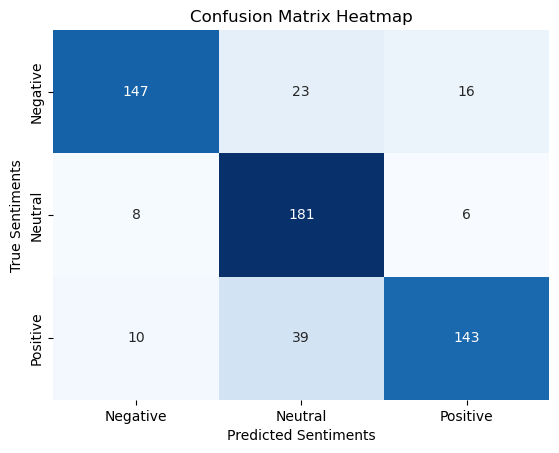

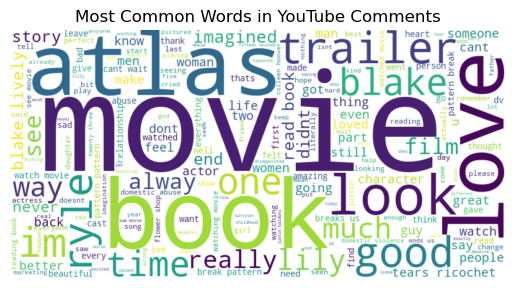

In [156]:
# Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Negative', 'Neutral', 'Positive'], 
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Sentiments')
plt.ylabel('True Sentiments')
plt.show()

# Word Cloud of Most Common Words
comment_words = ' '.join(final_data['cleaned_comment'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(comment_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in YouTube Comments')
plt.show()


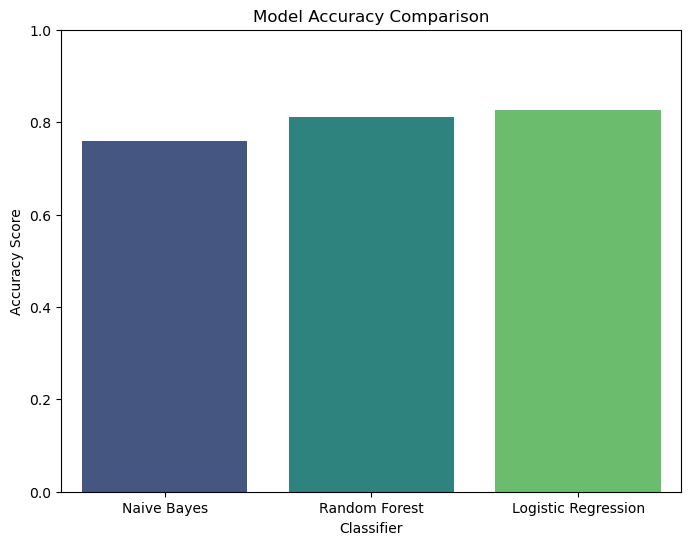

In [157]:
import matplotlib.pyplot as plt
import seaborn as sns

# Accuracy scores
nb_score = 0.76  # Assuming this is the Naive Bayes accuracy score
rf_score = accuracy_score(y_test, y_pred_rf)
log_reg_score = accuracy_score(y_test, y_pred_log_reg)


accuracy_scores = {
    'Naive Bayes': nb_score,
    'Random Forest': rf_score,
    'Logistic Regression': log_reg_score
}

# Creating the plot
plt.figure(figsize=(8, 6))
sns.barplot(x=list(accuracy_scores.keys()), y=list(accuracy_scores.values()), palette='viridis')
plt.title('Model Accuracy Comparison')
plt.xlabel('Classifier')
plt.ylabel('Accuracy Score')
plt.ylim(0, 1) 
plt.show()
